In [ ]:
import os

download_name = "frankenstein_with_splits.csv.bz2"
if not os.path.exists(download_name):
    import requests
    response = requests.get(f"https://raw.githubusercontent.com/bzitko/nlp_repo/main/assignments/a04/{download_name}")
    with open(download_name, "wb") as fp:
        fp.write(response.content)
    response.close()

name = "frankenstein_with_splits.csv"
if not os.path.exists(name):
    import bz2
    with open(download_name, 'rb') as bzf, open(name, 'wb') as fp:
        fp.write(bz2.decompress(bzf.read()))        

# Learning Embeddings with SkipGram

## Imports

In [1]:
import os
from argparse import Namespace
from collections import Counter
import json
import re
import string

import numpy as np
import pandas as pd
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import tqdm

## Data Vectorization classes

### The Vocabulary

In [2]:
class Vocabulary(object):
    def __init__(self, token_to_idx=None, mask_token="<MASK>", add_unk=True, unk_token="<UNK>"):

        if token_to_idx is None:
            token_to_idx = {}
        self._token_to_idx = token_to_idx

        self._idx_to_token = {idx: token 
                              for token, idx in self._token_to_idx.items()}
        
        self._add_unk = add_unk
        self._unk_token = unk_token
        self._mask_token = mask_token
        
        self.mask_index = self.add_token(self._mask_token)
        self.unk_index = -1
        if add_unk:
            self.unk_index = self.add_token(unk_token) 
        
    def to_serializable(self):
        return {'token_to_idx': self._token_to_idx, 
                'add_unk': self._add_unk, 
                'unk_token': self._unk_token, 
                'mask_token': self._mask_token}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self._token_to_idx:
            index = self._token_to_idx[token]
        else:
            index = len(self._token_to_idx)
            self._token_to_idx[token] = index
            self._idx_to_token[index] = token
        return index
            
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]

    def lookup_token(self, token):
        if self.unk_index >= 0:
            return self._token_to_idx.get(token, self.unk_index)
        else:
            return self._token_to_idx[token]

    def lookup_index(self, index):
        if index not in self._idx_to_token:
            raise KeyError("the index (%d) is not in the Vocabulary" % index)
        return self._idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size=%d)>" % len(self)

    def __len__(self):
        return len(self._token_to_idx)

In [3]:
class SkipGramVectorizer(object):

    def __init__(self, vocab):
        self.vocab = vocab

    def vectorize(self, context, vector_length=-1):
        indices = [self.vocab.lookup_token(token) for token in context.split(' ')]
        if vector_length < 0:
            vector_length = len(indices)

        out_vector = np.zeros(vector_length, dtype=np.int64)
        out_vector[:len(indices)] = indices
        out_vector[len(indices):] = self.vocab.mask_index

        return out_vector
    
    @classmethod
    def from_dataframe(cls, df):
        vocab = Vocabulary()
        for index, row in df.iterrows():
            for token in row.context.split(' '):
                vocab.add_token(token)
            vocab.add_token(row.target)
            
        return cls(vocab)

    @classmethod
    def from_serializable(cls, contents):
        vocab = Vocabulary.from_serializable(contents['vocab'])
        return cls(vocab=vocab)

    def to_serializable(self):
        return {'vocab': self.vocab.to_serializable()}

### The Dataset

In [4]:
class SkipGramDataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self._vectorizer = vectorizer
        
        measure_len = lambda context: len(context.split(" "))
        self._max_seq_length = max(map(measure_len, df.context))
        
        self.train_df = self.df[self.df.split=='train']
        self.train_size = len(self.train_df)

        self.val_df = self.df[self.df.split=='val']
        self.validation_size = len(self.val_df)

        self.test_df = self.df[self.df.split=='test']
        self.test_size = len(self.test_df)

        self._lookup_dict = {'train': (self.train_df, self.train_size),
                             'val': (self.val_df, self.validation_size),
                             'test': (self.test_df, self.test_size)}

        self.set_split('train')

    @classmethod
    def load_dataset_and_make_vectorizer(cls, csv):
        df = pd.read_csv(csv)
        train_df = df[df.split=='train']
        return cls(df, SkipGramVectorizer.from_dataframe(train_df))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, csv, vectorizer_filepath):
        df = pd.read_csv(csv)
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    @staticmethod
    def load_vectorizer_only(vectorizer_filepath):
        with open(vectorizer_filepath) as fp:
            return SkipGramVectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with open(vectorizer_filepath, "w") as fp:
            json.dump(self._vectorizer.to_serializable(), fp)

    def get_vectorizer(self):
        return self._vectorizer
        
    def set_split(self, split="train"):
        self._target_split = split
        self._target_df, self._target_size = self._lookup_dict[split]

    def __len__(self):
        return self._target_size

    def __getitem__(self, index):
        row = self._target_df.iloc[index]

        context_vector = self._vectorizer.vectorize(row.context, self._max_seq_length)
        target_index = self._vectorizer.vocab.lookup_token(row.target)

        return {'x_data': target_index,
                'y_target': context_vector}

    def get_num_batches(self, batch_size):
        return len(self) // batch_size
    
def generate_batches(dataset, batch_size, shuffle=True,
                     drop_last=True, device="cpu"): 
    dataloader = DataLoader(dataset=dataset, batch_size=batch_size,
                            shuffle=shuffle, drop_last=drop_last)

    for data_dict in dataloader:
        out_data_dict = {}
        for name, tensor in data_dict.items():
            out_data_dict[name] = data_dict[name].to(device)
        yield out_data_dict

## The Model: SkipGram

👍

In [5]:
class SkipGramClassifier(nn.Module): # Simplified SkipGram Model
    def __init__(self, vocabulary_size, embedding_size, context_size, padding_idx=0):
        super(SkipGramClassifier, self).__init__()
        self.context_size = context_size
        self.vocabulary_size = vocabulary_size
        self.embeddings =  nn.Embedding(num_embeddings=vocabulary_size, 
                                        embedding_dim=embedding_size,
                                        padding_idx=padding_idx)

        self.fc1 = nn.Linear(embedding_size, context_size * vocabulary_size)


    def forward(self, x_in):
        batch_size = x_in.shape[0]
        embedded = self.embeddings(x_in)
        # output = F.log_softmax(self.fc1(embedded), dim=1).view(batch_size, self.context_size, -1)
        # return output.permute(0, 2, 1)
        output = F.log_softmax(self.fc1(embedded), dim=1).view(batch_size, self.vocabulary_size, -1)
        return output
        
        

## Training Routine

### Helper functions

In [6]:
def make_train_state(args):
    return {'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'learning_rate': args.learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'model_filename': args.model_state_file}

def update_train_state(args, model, train_state):
    # Save one model at least
    if train_state['epoch_index'] == 0:
        torch.save(model.state_dict(), train_state['model_filename'])
        train_state['stop_early'] = False

    # Save model if performance improved
    elif train_state['epoch_index'] >= 1:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # If loss worsened
        if loss_t >= train_state['early_stopping_best_val']:
            # Update step
            train_state['early_stopping_step'] += 1
        # Loss decreased
        else:
            # Save the best model
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(model.state_dict(), train_state['model_filename'])

            # Reset early stopping step
            train_state['early_stopping_step'] = 0

        # Stop early ?
        train_state['stop_early'] = \
            train_state['early_stopping_step'] >= args.early_stopping_criteria

    return train_state

def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100

#### general utilities

In [7]:
def set_seed_everywhere(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

def handle_dirs(dirpath):
    if not os.path.exists(dirpath):
        os.makedirs(dirpath)

### Settings and some prep work

In [8]:
args = Namespace(
    # Data and Path information
    skipgram_csv="frankenstein_with_splits.csv",
    vectorizer_file="vectorizer.a04_1_skipgram.json",
    model_state_file="model_a04.1_skipgram.pth",
    save_dir=".",
    # Model hyper parameters
    embedding_size=50,
    # Training hyper parameters
    seed=1337,
    num_epochs=100,
    learning_rate=0.0001,
    batch_size=32,
    early_stopping_criteria=5,
    # Runtime options
    cuda=True,
    catch_keyboard_interrupt=True,
    reload_from_files=False,
    expand_filepaths_to_save_dir=True
)

if args.expand_filepaths_to_save_dir:
    args.vectorizer_file = os.path.join(args.save_dir,
                                        args.vectorizer_file)

    args.model_state_file = os.path.join(args.save_dir,
                                         args.model_state_file)
    
    print("Expanded filepaths: ")
    print("\t{}".format(args.vectorizer_file))
    print("\t{}".format(args.model_state_file))
    

# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")
    
print("Using CUDA: {}".format(args.cuda))


# Set seed for reproducibility
set_seed_everywhere(args.seed, args.cuda)

# handle dirs
handle_dirs(args.save_dir)

Expanded filepaths: 
	./vectorizer.json
	./model_04.1_skipgram.pth
Using CUDA: False


### Initializations

In [9]:
if args.reload_from_files:
    print("Loading dataset and loading vectorizer")
    dataset = SkipGramDataset.load_dataset_and_load_vectorizer(args.skipgram_csv,
                                                               args.vectorizer_file)
else:
    print("Loading dataset and creating vectorizer")
    dataset = SkipGramDataset.load_dataset_and_make_vectorizer(args.skipgram_csv)
    dataset.save_vectorizer(args.vectorizer_file)
    
vectorizer = dataset.get_vectorizer()
print(vectorizer)

classifier = SkipGramClassifier(vocabulary_size=len(vectorizer.vocab), 
                                embedding_size=args.embedding_size,
                                context_size=dataset._max_seq_length)


Loading dataset and creating vectorizer


### Training loop

In [10]:
classifier = classifier.to(args.device)
    
loss_func = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=args.learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                 mode='min', factor=0.5,
                                                 patience=1)
train_state = make_train_state(args)

epoch_bar = tqdm(desc='training routine', 
                 total=args.num_epochs,
                 position=0)

dataset.set_split('train')
train_bar = tqdm(desc='split=train',
                 total=dataset.get_num_batches(args.batch_size),  
                 position=1, 
                 leave=True)
dataset.set_split('val')
val_bar = tqdm(desc='split=val',
               total=dataset.get_num_batches(args.batch_size), 
               position=1, 
               leave=True)

try:
    for epoch_index in range(args.num_epochs):
        train_state['epoch_index'] = epoch_index

        # Iterate over training dataset

        # setup: batch generator, set loss and acc to 0, set train mode on

        dataset.set_split('train')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.0
        running_acc = 0.0
        classifier.train()

        for batch_index, batch_dict in enumerate(batch_generator):
            # the training routine is these 5 steps:

            # --------------------------------------
            # step 1. zero the gradients
            optimizer.zero_grad()

            # step 2. compute the output
            y_pred = classifier(x_in=batch_dict['x_data'])

            # step 3. compute the loss
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # step 4. use loss to produce gradients
            loss.backward()

            # step 5. use optimizer to take gradient step
            optimizer.step()
            # -----------------------------------------
            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)

            # update bar
            train_bar.set_postfix(loss=running_loss, acc=running_acc, 
                            epoch=epoch_index)
            train_bar.update()

        train_state['train_loss'].append(running_loss)
        train_state['train_acc'].append(running_acc)

        # Iterate over val dataset

        # setup: batch generator, set loss and acc to 0; set eval mode on
        dataset.set_split('val')
        batch_generator = generate_batches(dataset, 
                                           batch_size=args.batch_size, 
                                           device=args.device)
        running_loss = 0.
        running_acc = 0.
        classifier.eval()

        for batch_index, batch_dict in enumerate(batch_generator):

            # compute the output
            y_pred =  classifier(x_in=batch_dict['x_data'])

            # step 3. compute the loss)
            loss = loss_func(y_pred, batch_dict['y_target'])
            loss_t = loss.item()
            running_loss += (loss_t - running_loss) / (batch_index + 1)

            # compute the accuracy
            acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
            running_acc += (acc_t - running_acc) / (batch_index + 1)
            val_bar.set_postfix(loss=running_loss, acc=running_acc, 
                                epoch=epoch_index)
            val_bar.update()

        train_state['val_loss'].append(running_loss)
        train_state['val_acc'].append(running_acc)

        train_state = update_train_state(args=args, model=classifier,
                                         train_state=train_state)

        scheduler.step(train_state['val_loss'][-1])

        if train_state['stop_early']:
            break

        train_bar.n = 0
        val_bar.n = 0
        epoch_bar.update()
except KeyboardInterrupt:
    print("Exiting loop")


training routine:   0%|          | 0/100 [00:00<?, ?it/s]

split=train:   0%|          | 0/1984 [00:00<?, ?it/s]

split=val:   0%|          | 0/425 [00:00<?, ?it/s]

In [11]:
# compute the loss & accuracy on the test set using the best available model

classifier.load_state_dict(torch.load(train_state['model_filename']))
classifier = classifier.to(args.device)
loss_func = nn.CrossEntropyLoss()

dataset.set_split('test')
batch_generator = generate_batches(dataset, 
                                   batch_size=args.batch_size, 
                                   device=args.device)
running_loss = 0.
running_acc = 0.
classifier.eval()

for batch_index, batch_dict in enumerate(batch_generator):
    # compute the output
    y_pred =  classifier(x_in=batch_dict['x_data'])
    
    # compute the loss
    loss = loss_func(y_pred, batch_dict['y_target'])
    loss_t = loss.item()
    running_loss += (loss_t - running_loss) / (batch_index + 1)

    # compute the accuracy
    acc_t = compute_accuracy(y_pred, batch_dict['y_target'])
    running_acc += (acc_t - running_acc) / (batch_index + 1)

train_state['test_loss'] = running_loss
train_state['test_acc'] = running_acc


In [12]:
print("Test loss: {};".format(train_state['test_loss']))
print("Test Accuracy: {}".format(train_state['test_acc']))

Test loss: 7.048454321692968;
Test Accuracy: 79.79411764705885


### Trained Embeddings

In [13]:
def pretty_print(results):
    """
    Pretty print embedding results.
    """
    for item in results:
        print ("...[%.2f] - %s"%(item[1], item[0]))

def get_closest(target_word, word_to_idx, embeddings, n=5):
    """
    Get the n closest
    words to your word.
    """

    # Calculate distances to all other words
    
    word_embedding = embeddings[word_to_idx[target_word.lower()]]
    distances = []
    for word, index in word_to_idx.items():
        if word == "<MASK>" or word == target_word:
            continue
        distances.append((word, torch.dist(word_embedding, embeddings[index])))
    
    results = sorted(distances, key=lambda x: x[1])[1:n+2]
    return results


In [14]:
word = "good"
embeddings = classifier.embeddings.weight.data
word_to_idx = vectorizer.vocab._token_to_idx
pretty_print(get_closest(word, word_to_idx, embeddings, n=5))

...[7.24] - crossed
...[7.33] - joined
...[7.50] - annihilation
...[7.58] - torments
...[7.59] - lessons
...[7.61] - arise


In [15]:
target_words = ['frankenstein', 'monster', 'science', 'sickness', 'lonely', 'happy']

embeddings = classifier.embeddings.weight.data
word_to_idx = vectorizer.vocab._token_to_idx

for target_word in target_words: 
    print(f"======={target_word}=======")
    if target_word not in word_to_idx:
        print("Not in vocabulary")
        continue
    pretty_print(get_closest(target_word, word_to_idx, embeddings, n=5))

=======frankenstein=======
...[7.57] - mode
...[7.59] - irradiated
...[7.77] - men
...[7.81] - strain
...[7.88] - enslaved
...[7.90] - wound
=======monster=======
...[7.50] - griefs
...[7.51] - permit
...[7.62] - relief
...[7.71] - opaque
...[7.78] - skin
...[7.81] - trifling
=======science=======
...[7.43] - gospel
...[7.49] - mist
...[7.54] - tempted
...[7.55] - mutual
...[7.62] - oxford
...[7.66] - nearly
=======sickness=======
...[6.63] - awoke
...[6.64] - foundations
...[6.67] - probabilities
...[6.70] - literally
...[6.76] - consoles
...[6.76] - insanity
=======lonely=======
...[7.01] - unveiled
...[7.01] - ought
...[7.02] - moonlight
...[7.16] - heartily
...[7.22] - bed
...[7.23] - undiscovered
=======happy=======
...[6.64] - bottom
...[6.69] - penetrated
...[6.80] - injury
...[6.85] - devices
...[6.89] - evening
...[6.89] - joys


In [84]:
from numpy.linalg import norm

dists = []
sims = []
sims1 = []
sims2 = []
scores = []

emb = classifier.embeddings.weight.data
with open("wordsim_similarity_goldstandard.txt") as fp:
    for line in fp:
        w1, w2, score = line.split()
        score = float(score)
        idx1 = vectorizer.vocab.lookup_token(w1)
        idx2 = vectorizer.vocab.lookup_token(w2)
        if idx1 != idx2 != 1:
            e1, e2 = emb[idx1], emb[idx2]
            n1, n2 = e1.numpy(), e2.numpy()
            sim = F.cosine_similarity(e1, e2, dim=0).item()
            dist = torch.dist(e1, e2).item()
            sim1 = (torch.sum(e1 * e2)) / (torch.sum(e1**2) ** 0.5 * torch.sum(e2 ** 2) ** 0.5)
            sim1 = sim1.item()

            sim2 = 5 * np.dot(n1, n2) / (norm(n1) * norm(n2)) + 5
 
            scores.append(score)
            dists.append(dist)
            sims.append(sim)
            sims1.append(sim1)
            sims2.append(sim2)
            print(w1, w2, float(score), sim, sim2)

doctor nurse 7.0 0.12387172877788544 5.6193587357363475
student professor 6.81 0.06943700462579727 5.347185061029062
smart stupid 5.81 -0.034458670765161514 4.827706610986377
wood forest 7.73 0.110124371945858 5.550621925342652
king queen 8.58 -0.015770800411701202 4.921145915251817
fuck sex 9.44 -0.07525528967380524 4.6237236133784085
physics chemistry 7.35 -0.13122977316379547 4.3438511573361565
vodka brandy 8.13 -0.15378648042678833 4.231067693669792
drink eat 6.87 0.14110016822814941 5.705500793941414
gem jewel 8.96 -0.004307782277464867 4.978461151913526
journey voyage 9.29 0.11439583450555801 5.571979133094533
coast shore 9.1 -0.08165182918310165 4.591740774399337
midday noon 9.29 0.07070131599903107 5.353506591278584
furnace stove 8.79 -0.10266588628292084 4.486670630374197
tiger animal 7.0 -0.18223978579044342 4.088801114941699
psychology science 6.71 0.02004077471792698 5.10020397744267
psychology discipline 5.58 -0.04393485188484192 4.780325707494832
planet star 8.45 0.139538

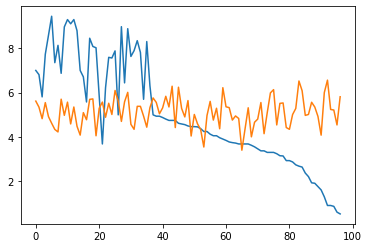

In [89]:
import matplotlib.pyplot as plt

plt.plot(scores)
plt.plot(sims2)

In [93]:
df = pd.DataFrame({"scores": scores, 
                   "sims": sims, 
                   "sims1": sims1, 
                   "sims2": sims2})

df["scores"].corr(df["sims2"])

-0.08884047854748604

In [94]:
from annoy import AnnoyIndex

ModuleNotFoundError: No module named 'annoy'